In [25]:
import numpy as np
import skimage
from skimage import io
import imageio
import scipy
import threading
import matplotlib.pyplot as plt
import timeit
import time

In [60]:

def extend(size, img):
    new_img = np.array([np.zeros((img.shape[1] + 2 * size, 3)) for i in range(0, img.shape[0] + 2 * size)])
    new_img[size:img.shape[0] + size,  size:img.shape[1] + size, ] = img.copy()
    for i in range(0, size):
        for j in range(0, img.shape[0]):
            new_img[j + size][i] = new_img[j+ size][size]
            new_img[j + size][i + size + img.shape[1]] = new_img[j + size][size + img.shape[1] - 1]
    for i in range(0, size):
        for j in range(0, new_img.shape[1]):
            new_img[i][j] = new_img[size][j]
            new_img[size + img.shape[0] + i][j] = new_img[size + img.shape[0] - 1][j]
    return new_img

def dist(img1, img2):
    return np.sqrt(np.power(np.linalg.norm(img1 - img2), 2)/(img1.shape[0] * img1.shape[1]))

def median(r, img):
    res = np.zeros((img.shape[0], img.shape[1], 3))
    size = 2 * r + 1
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            for k in range(0, img.shape[2]):
                window = img[max(0, i - r): min(img.shape[0] - 1, i + r + 1), max(0, j - r): min(img.shape[1] - 1, j + r + 1), k].copy().flatten()
                window = sorted(window)
                res[i][j][k] = window[(len(window) + 1) // 2 - 1]
    return res

def gauss(loc, sigma, x):
    return np.exp(-(x - loc) * (x - loc)/(2 * sigma * sigma))

def bilateral(sigma_d, sigma_r, img):
    treshold = 2
    extended = extend(treshold, img).astype(np.uint8)
    res = np.zeros((img.shape[0], img.shape[1], 3), dtype = float)
    gaussian_d = np.array([[np.exp((-(i - treshold) * (i - treshold) - (j - treshold)*(j - treshold))/(2 * sigma_d * sigma_d))/(2 * sigma_d * sigma_d * np.pi) for j in range(0, treshold * 2 + 1)] for i in range(0, treshold * 2 + 1)])
    gaussian_r = np.array([gauss(0, sigma_r, i) for i in range(-255, 256)])
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            for k in range(0, 3):
                sum = 0
                for k1 in range(0, 2 * treshold + 1):
                    for k2 in range(0, 2 * treshold + 1):
                        gauss_r_d = gaussian_d[k1][k2] * gaussian_r[int(extended[i + treshold][j + treshold][k]) - int(extended[i + k1][j + k2][k]) + 255]
                        res[i][j][k] += gauss_r_d * extended[i + k1][j + k2][k]
                        sum += gauss_r_d
                res[i][j][k] /= sum
    return res

def gauss_filter(sigma, img):
    treshold = 3
    extended = extend(treshold, img).astype(np.uint8)
    res = np.zeros((img.shape[0], img.shape[1], 3), dtype = float)
    gaussian = np.array([[np.exp((-(i - treshold) ** 2 - (j - treshold) ** 2) / (2 * sigma * sigma)) for j in range (0, treshold * 2 + 1)] for i in range (0, 2 * treshold + 1)])
    sum = 0
    for k1 in range(0, 2 * treshold + 1):
        for k2 in range(0, 2 * treshold + 1) :
            sum += gaussian[k1][k2]
    for i in range(0, img.shape[0]):
        for j in range (0, img.shape[1]):
            for k in range(0, 3):
                res[i][j][k] = np.sum(extended[i: i + 2 * treshold + 1, j: j + 2 * treshold + 1, k]* gaussian)
                res[i][j][k] /= sum
    return res

def query(noise_level):
    var2sigma_d = {5.: 0.5, 10.: 1.0, 20.: 3.0, 30.: 5.0, 40.: 5.0, 60.: 5.0, 80.: 5.0, 120.: 6.0, 180.: 8.0}
    var2sigma_r = {5.: 5  , 10.:  15, 20.: 30., 30.: 40 , 40.: 60 , 60.: 120, 80.: 160, 120.: 210, 180.: 290}
    vars = [5.0, 10., 20., 30., 40., 60., 80., 120., 180.]
    r = 1
    sigma_spatial = 0
    sigma_color = 0
    for i in range(0, len(vars)):
        if vars[i] > noise_level:
            if i == 0:
                sigma_spatial = var2sigma_d[vars[0]]
                sigma_color = var2sigma_r[vars[0]]
                break
            else:
                sigma_spatial = ((noise_level - vars[i - 1]) * var2sigma_d[vars[i]] + (vars[i] - noise_level) * var2sigma_d[vars[i - 1]]) / (vars[i] - vars[i - 1])
                sigma_color = ((noise_level - vars[i - 1]) * var2sigma_r[vars[i]] + (vars[i] - noise_level) * var2sigma_r[vars[i - 1]]) / (vars[i] - vars[i - 1])
                break
        elif i == len(vars) - 1:
            sigma_spatial = var2sigma_d[vars[-1]]
            sigma_color = var2sigma_r[vars[-1]]
    if noise_level > 70:
        r = 2
    return [r, sigma_spatial, sigma_color]

def calc_noise(img):
    new_sigma = 1.
    old_sigma = 0
    while(abs(old_sigma - new_sigma) > 0.05):
        old_sigma = new_sigma
        var = variance(gauss_filter(new_sigma, img), img)
        new_sigma = query(var)[1]
    return var


def variance(denoised, noised):
    return np.sqrt(np.sum((denoised - noised) ** 2)/(noised.shape[0] * noised.shape[1] * noised.shape[2] - 1))

def mse(img1, img2):
    return np.sum((img1 - img2) ** 2)/(img1.shape[0] * img1.shape[1] * img1.shape[2])

def denoise(noised):
    params = query(calc_noise(noised))
    return bilateral(params[1], params[2], median(params[0], noised))

def find_optimal_sigma(noise_sigma, img):
    noise = np.random.normal(0., noise_sigma, (img.shape[0], img.shape[1]))
    noised_img = img + noise
    for i in range(0, lena.shape[0]):
        for j in range(0, lena.shape[1]):
            if noised_img[i][j] < 0:
                noised_img[i][j] = 0
            elif noised_img[i][j] > 255:
                noised_img[i][j] = 255
    imgs = [gauss_filter(i * 0.1 + 0.4, noised_img) for i in range(0, 12)]
    min = mse(imgs[0], img)
    argmin = 0
    for index in range(0, len(imgs)):
        current_mse = mse(imgs[index], img)
        if mse(imgs[index], img) < min:
            min = current_mse
            argmin = index
    print(noise_sigma)
    return argmin * 0.25 + 0.4 + (noise_sigma - 4.) * 0.025

def find_optimal_params(noise_level, img, sigma_d_min, sigma_d_max, sigma_r_min, sigma_r_max):
    min_mse = 1000000
    argmin = [0, 0, 0]
    noise = np.random.normal(0., noise_level, (img.shape[0], img.shape[1]))
    noised_img = img + noise
    for i in range(0, lena.shape[0]):
        for j in range(0, lena.shape[1]):
            if noised_img[i][j] < 0:
                noised_img[i][j] = 0
            elif noised_img[i][j] > 255:
                noised_img[i][j] = 255
    for r in range(1, 3, 1):
        for sigma_d in range(sigma_d_min, sigma_d_max, 1):
            for sigma_r in range(sigma_r_min, sigma_r_max, 10):
                cur_mse = mse(bilateral(float(sigma_d)/2, sigma_r, median(r, noised_img)), img)
                if cur_mse < min_mse:
                    min_mse = cur_mse
                    argmin[0] = r
                    argmin[1] = float(sigma_d)/2
                    argmin[2] = sigma_r
                print(r, float(sigma_d)/2, sigma_r, cur_mse)
    print('_______', noise_level, argmin, min_mse)
    return argmin

                
            

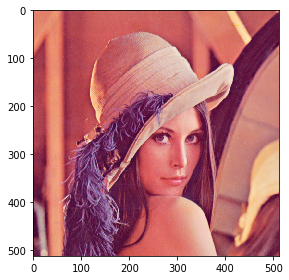

In [61]:
lena = skimage.io.imread("lena.bmp").astype(float)
skimage.io.imshow(lena.astype(np.uint8))

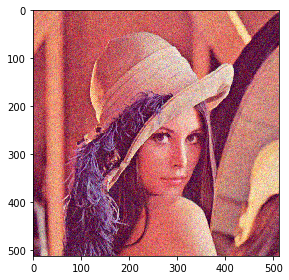

In [42]:
noise = np.random.normal(0., 20., (lena.shape[0], lena.shape[1], lena.shape[2]))
noised_lena = lena + noise
for i in range(0, lena.shape[0]):
    for j in range(0, lena.shape[1]):
        for k in range(0, lena.shape[2]):
            if noised_lena[i][j][k] < 0:
                noised_lena[i][j][k] = 0
            elif noised_lena[i][j][k] > 255:
                noised_lena[i][j][k] = 255
skimage.io.imshow(noised_lena.astype(np.uint8))

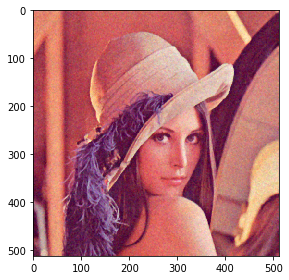

In [50]:
median_lena = median(1, noised_lena)
skimage.io.imshow(median_lena.astype(np.uint8))

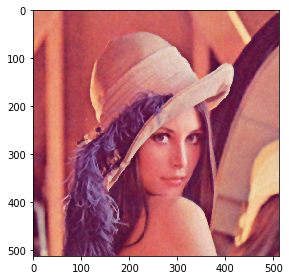

In [57]:
bilateral_lena = bilateral(1., 40, noised_lena)
skimage.io.imshow(bil.astype(np.uint8))

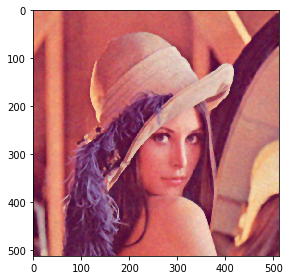

In [62]:
denoised_lena = denoise(noised_lena)
skimage.io.imshow(denoised_lena.astype(np.uint8))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


0.0
387.5304465240594
101.32805623686677
92.87433834207245
69.8365649077882
0.30473320000055537


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


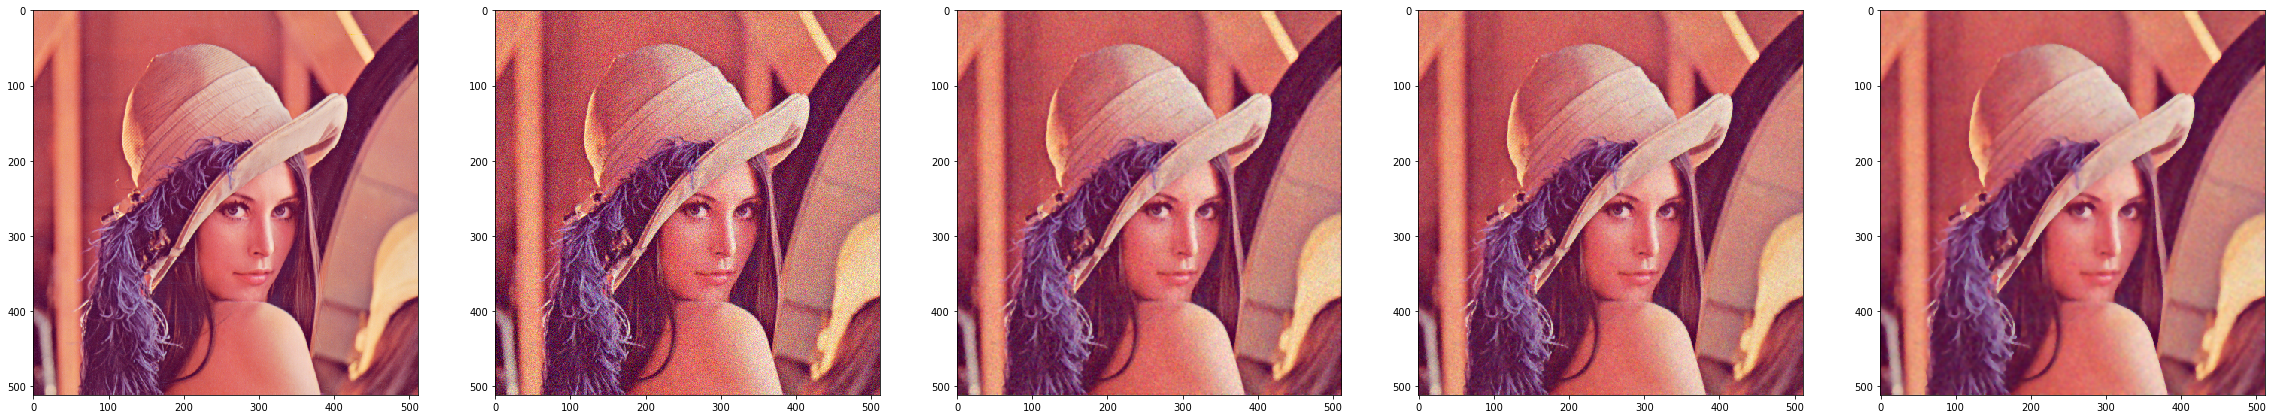

In [63]:
t0 = time.clock()
imgs = [lena, noised_lena, median_lena, bilateral_lena, denoised_lena]
_, axs = plt.subplots(ncols = len(imgs), figsize = (40, 40))

for index in range(0, len(imgs)):
    print(mse(lena, imgs[index]))
    axs[index].imshow(imgs[index].astype(np.uint8))
    
print(time.clock() - t0)